#Exercise 4
## Using LSTMs, see if you can write Shakespeare!
In this course you’ve done a lot of NLP and text processing. This week you trained with a dataset of Irish songs to create traditional-sounding poetry. For this week’s exercise, you’ll take a corpus of Shakespeare sonnets, and use them to train a model. Then, see if that model can create poetry!

In [18]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.utils as ku 
import numpy as np
import tensorflow as tf

# Data download

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt

--2020-08-28 02:34:03--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2020-08-28 02:34:03 (96.1 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



In [3]:
data = open('/tmp/sonnets.txt').read()
corpus = data.lower().split("\n")

#Create and fit tokenizer. Add one word more for OOV to the vocab size.
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# Create sequences.
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# Padd sequences. (pre -> to extract labels) 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# Extract labels and features.
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
label = ku.to_categorical(label, num_classes=total_words)

In [23]:
model = Sequential()
#We substract 1 because we substracted one for the labels of each sequence of xs.
model.add(Embedding(total_words, 250,input_length = max_sequence_len - 1))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.15))
model.add(Dense(128))
model.add(Dense(total_words, activation='softmax'))
opt = Adam(lr = 0.001)
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
print(model.summary())


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 10, 250)           802750    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 10, 256)           388096    
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 256)           0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 128)               164352    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 3211)             

In [24]:
 history = model.fit(predictors, label, epochs=100, verbose=1)

Epoch 1/100
484/484 [==============================] - 8s 16ms/step - loss: 6.8708 - accuracy: 0.0243
Epoch 2/100
484/484 [==============================] - 8s 17ms/step - loss: 6.4372 - accuracy: 0.0333
Epoch 3/100
484/484 [==============================] - 8s 16ms/step - loss: 6.2647 - accuracy: 0.0365
Epoch 4/100
484/484 [==============================] - 8s 16ms/step - loss: 6.1089 - accuracy: 0.0411
Epoch 5/100
484/484 [==============================] - 7s 15ms/step - loss: 5.9211 - accuracy: 0.0539
Epoch 6/100
484/484 [==============================] - 8s 16ms/step - loss: 5.7222 - accuracy: 0.0623
Epoch 7/100
484/484 [==============================] - 8s 16ms/step - loss: 5.5350 - accuracy: 0.0696
Epoch 8/100
484/484 [==============================] - 8s 16ms/step - loss: 5.3395 - accuracy: 0.0748
Epoch 9/100
484/484 [==============================] - 7s 15ms/step - loss: 5.1574 - accuracy: 0.0785
Epoch 10/100
484/484 [==============================] - 8s 16ms/step - loss: 4.979

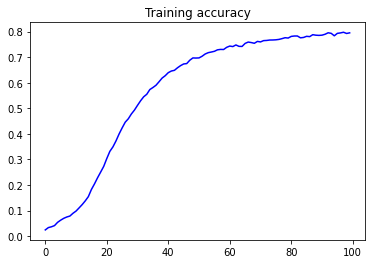

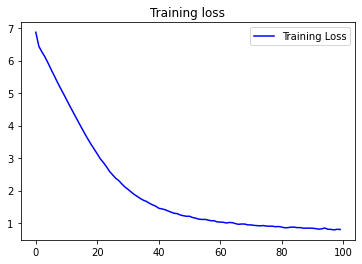

In [25]:
#Plot results
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [28]:
#Predict next words with the model trained with a initial seed text.
seed_text = "Leonardo, you are"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

Leonardo, you are so strongly in my purpose bred of sense despite me bail can bright ' have no burn that of mine eye out of wide eyes all ill still kind no praise happy bright than power again upon a devil exchanged flatter in the ground night will no treasure due of mine heart untrue new 'will' more friend hath me ' keeps you not i sing for thee none none see on thy granting you flatter to decay liberty 'will' ' will no sinful brow laws thy friend ' of no such time of me still live contains so truth '
